# Wine Data Clustering: Unsupervised Data Mining

Author: **Marcin Sikorski**<br>
Date: September, 2022

**Introduction**

Clustering is the machine learning task of dividing the population or data points into a number of groups such that data points in the same groups are more similar to other data points in the same group than those in other groups. It is useful for exploring data. If there are many cases and no obvious natural groupings, clustering data mining algorithms can be used to find natural groupings. Clustering analysis identifies clusters embedded in the data. A cluster (or group) is a collection of data objects that are similar in some sense to one another, or contains similar features. It can be useful for identifying homogeneous groups on which to build further supervised models. Cluster analysis is used in various real-life situations, such as:
* market or customer segmentation;
* anomaly detection;
* image preprocessing;
* search result grouping;
* entity resolution;
* biology and medical imaging.

The goal of this repository is to model wine quality based on physicochemical tests. We will perform cluster analysis, an unsupervised learning task. We will accept that this dataset has no classes and search for patterns based on the attributes. The clustering will be performed with these approachs:
* k-means;
* agglomerative;
* spectral.

**Table of Contents:**
1. Investigating the Dataset
2. Normalizing Data
3. Evaluating Clustering Algorithms
4. k-Means Clustering
5. Agglomerative Clustering
6. Spectral Clustering
7. Dimensionality Reduction Using Principal Component Analysis (PCA)
8. Clustering After Reducing Dimensions
9. Summary

**Data Description**

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. We will focus only on the white wine set. The dataset was downloaded from UCI Machine Learning Repository [link](https://archive.ics.uci.edu/ml/datasets/wine+quality). All variables are continuous. The last column of this dataset - quality, is the target data used for other data science tasks (e.g. classification) and will be dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing data and creating dataframe
def load_dataset():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
    df = pd.read_csv(url, header=0, sep=';')
    df = df.iloc[:, :-1]
    return df

df = load_dataset()
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0


### 1. Investigating the Dataset

We loaded the data into the notebook. It is time to investigate the data to summarize the dataset, and get a good understanding. At this stage, we will search for outliers, completness, duplicates, and possible patterns.

To detect outliers we will implement the IQR method. We will define the spread difference between the 75th and 25th percentiles of the data.

In [2]:
# displaying data types, null values, and possible outliers in each column
def dataframe_summary():
    
    # lists
    var_list = df.columns.to_list()
    dtype_list = []
    null_list = []
    
    # looping through columns
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        null_list.append(df[col].isnull().sum())
    
    # outliers IQR
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    k = 1.5
    outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
    
    # stacking lists into dictionary
    dict = {'Variable': var_list, 'Data type': dtype_list, 'Null values': null_list, 'Outliers': outlier_list}
    
    return pd.DataFrame(dict).style.hide_index()
    
dataframe_summary()

Variable,Data type,Null values,Outliers
fixed acidity,float64,0,119
volatile acidity,float64,0,186
citric acid,float64,0,270
residual sugar,float64,0,7
chlorides,float64,0,212
free sulfur dioxide,float64,0,50
total sulfur dioxide,float64,0,19
density,float64,0,5
pH,float64,0,75
sulphates,float64,0,124


There are no missing values in the dataframe. All attributes are continuous and contain double-precision numbers. We summed up outliers for each variable.

We will proceed further and visualize outliers with box plots.

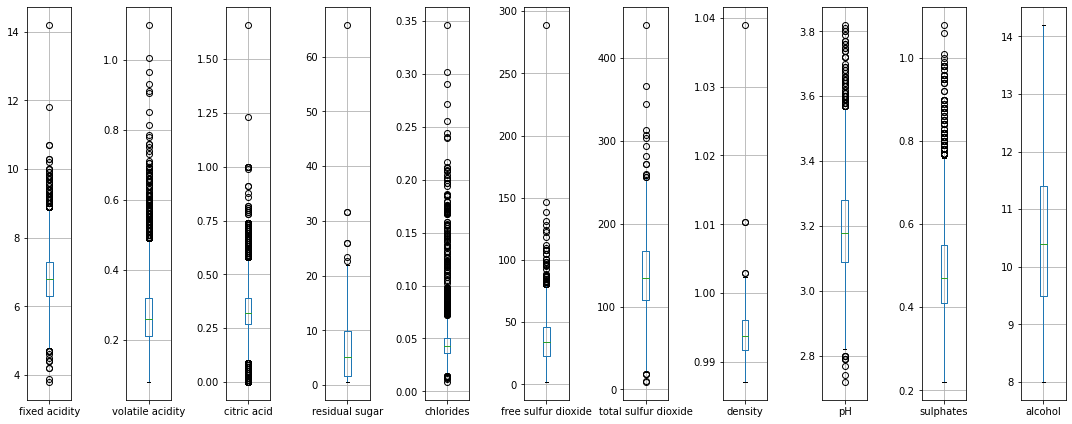

In [3]:
# plotting box plots
def plot_box_plots():
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 6))
    
    # visualizing IQR results with box plots
    for i in range(len(df.columns)):
        df.boxplot(column=df.columns[i], ax=ax[i], vert=True)
    
    fig.tight_layout()
    plt.show()
        
plot_box_plots()

Only alcohol column has no outliers. The least outliers are visible for: residual sugar and density. The most errors are in: chlorides and volatile acidity.

We do not have enough knowledge of the acceptable ranges for all these attributes. We can remove the rows containing extreme values, but this action may be too risky. This can lead us to loosing useful data and we are not sure if these points are indeed mistakes. We will proceed further without adjusting these values.

In [4]:
# displaying duplicate rows (if any)
df.loc[df.duplicated(keep='first')]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.100000
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.800000
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.500000
20,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.800000
...,...,...,...,...,...,...,...,...,...,...,...
4828,6.4,0.23,0.35,10.3,0.042,54.0,140.0,0.99670,3.23,0.47,9.200000
4850,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.100000
4851,6.4,0.33,0.44,8.9,0.055,52.0,164.0,0.99488,3.10,0.48,9.600000
4856,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000


In [5]:
# removing duplicate rows
df = df.drop_duplicates()

# descriptive statistics of dataset
round(df.describe(), 2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00
mean,6.84,0.28,0.33,5.91,0.05,34.89,137.19,0.99,3.20,0.49,10.59
std,0.87,0.10,0.12,4.86,0.02,17.21,43.13,0.00,0.15,0.11,1.22
min,3.80,0.08,0.00,0.60,0.01,2.00,9.00,0.99,2.72,0.22,8.00
25%,6.30,0.21,0.27,1.60,0.04,23.00,106.00,0.99,3.09,0.41,9.50
50%,6.80,0.26,0.32,4.70,0.04,33.00,133.00,0.99,3.18,0.48,10.40
75%,7.30,0.33,0.39,8.90,0.05,45.00,166.00,1.00,3.29,0.55,11.40
max,14.20,1.10,1.66,65.80,0.35,289.00,440.00,1.04,3.82,1.08,14.20


We removed duplicates. These rows do not bring much value in data modelling. Min value row displays 0.0 for citric acid column. This should be acceptable and not a measurement error.

We will plot a heatmap to find any interesting correlations between variables.

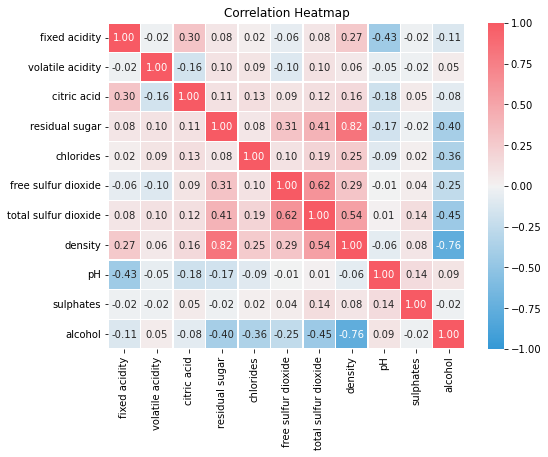

In [6]:
# plotting heatmap
def plot_heatmap():
    from seaborn import heatmap, diverging_palette
    
    # custom colormap
    cmap = diverging_palette(240, 10, s=90, l=60, center='light', as_cmap=True)
    
    # plot heatmap
    plt.figure(figsize=(8, 6))
    heatmap(df.corr(method='pearson'), annot=True, cbar=True, vmin=-1, vmax=1, linewidths=.5, fmt='.2f', cmap=cmap)
    plt.title('Correlation Heatmap')
    plt.show()

plot_heatmap()

There are some strong, interesting co-dependencies between some of the features:
* alcohol vs. density;
* total sulfur dioxide (TSO2) vs. free sulfur dioxide (FSO2);
* density vs. residual sugar.

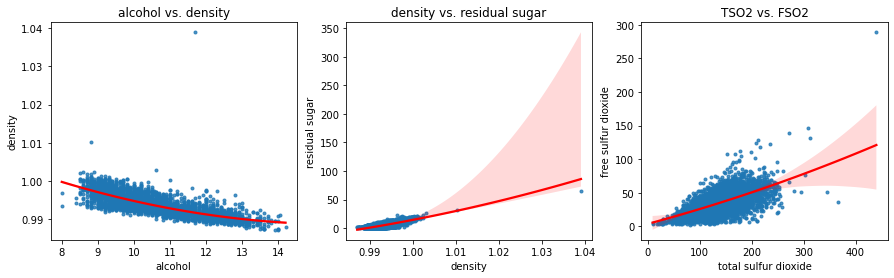

In [7]:
# plotting reg plots and fitting trend splines
def plot_reg_plots():
    from seaborn import regplot
    
    plt.figure(figsize=(15, 4))
    
    # subplot 1
    plt.subplot(1, 3, 1)
    regplot(data=df, x='alcohol', y='density', marker='.', line_kws={'color': 'red'}, order=2, truncate=True)
    plt.title('alcohol vs. density')
    
    # subplot 2
    plt.subplot(1, 3, 2)
    regplot(data=df, x='density', y='residual sugar', marker='.', line_kws={'color': 'red'}, order=2, truncate=True)
    plt.title('density vs. residual sugar')
    
    # subplo 3
    plt.subplot(1, 3, 3)
    regplot(data=df, x='total sulfur dioxide', y='free sulfur dioxide', marker='.', line_kws={'color': 'red'},
            order=2, truncate=True)
    plt.title('TSO2 vs. FSO2')
    plt.show

plot_reg_plots()

When alcohol percentage decreases, density grows (strong, negative relationship), and high level of residual sugar tend to have higher density and therefore chemical solution (strong, positive relationship).<br>
Wine with high TSO2 tend to have higher FSO2. FSO2 form naturally in the fermentation process. TSO2 in conjunction with FSO2, is a sense of how "clean" a wine is. A wine with high TSO2 has usually had many SO2 additions made over its lifetime, usually because the FSO2 keeps dropping [source](https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too/).

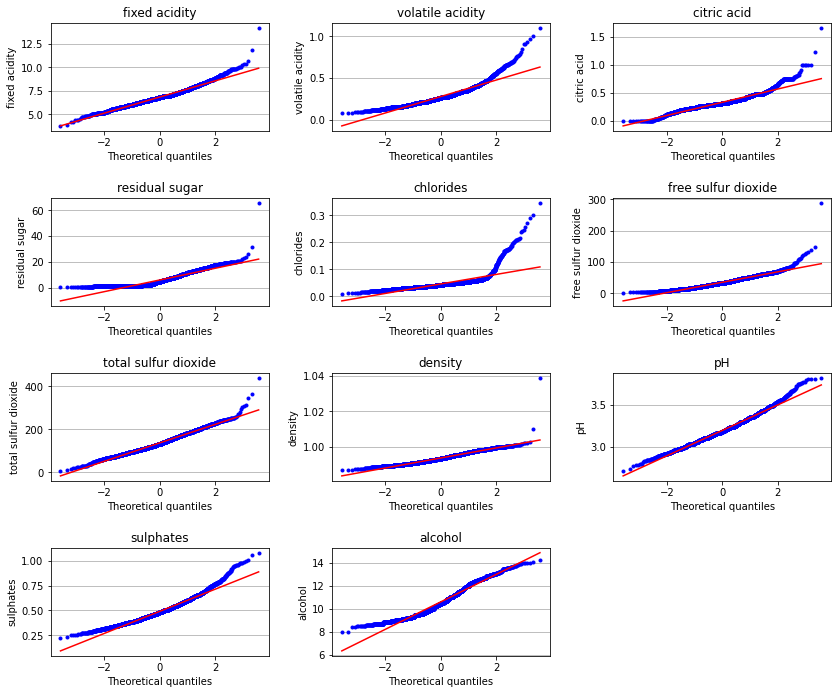

In [8]:
# probability plots
def plot_probability_plots():
    from scipy.stats import probplot

    plt.subplots(figsize=(12, 10))
    
    count = 1
    # probability plots for continuous predictors
    for i in df.columns:
        ax = plt.subplot(4, 3, count)
        probplot(df[i].values, dist='norm', plot=ax, fit=True)
        ax.get_lines()[0].set_markersize(3)
        plt.title('{}'.format(i))
        plt.tight_layout(pad=2)
        plt.ylabel(i)
        plt.grid(axis='y')
        count += 1
    plt.show()

plot_probability_plots()

Non of the features follow a perfect Gaussian distribution. The columns closest to normal distribution are:
* total sulfur dioxide;
* density;
* pH.

We can spot that the features most deviating from the normal distribution are also the ones with the most outliers observed on box plots (e.g. volatile acidity, chlorides). Although the alcohol attribute does not have a Gaussian distribution, the curve might be more balanced relative to the red line. This might be why the IQR test did not detect errors in this column.

### 2. Normalizing Data

Clustering algorithms in geometrical context are distance based. Therefore, rescaling data is a must. We will implement the <code>MinMaxScaler</code> method from <code>sklearn</code> library. The transformation shifts the values as given:

$$X_i' = \frac{X_i - min(X)}{max(X) - min(X)},$$

where $X_i$ is the original value, $min(X)$ the minimum value in feature range, and $max(X)$ the maximum value.

In [9]:
# normalizing data
def normalizing_data(data):
    from sklearn.preprocessing import MinMaxScaler
    
    # rescaling data
    scaler = MinMaxScaler()
    norm_features = scaler.fit_transform(data)
    return norm_features

df2 = normalizing_data(data=df)
df2

array([[0.30769231, 0.18627451, 0.21686747, ..., 0.25454545, 0.26744186,
        0.12903226],
       [0.24038462, 0.21568627, 0.20481928, ..., 0.52727273, 0.31395349,
        0.24193548],
       [0.41346154, 0.19607843, 0.24096386, ..., 0.49090909, 0.25581395,
        0.33870968],
       ...,
       [0.25961538, 0.15686275, 0.11445783, ..., 0.24545455, 0.27906977,
        0.22580645],
       [0.16346154, 0.20588235, 0.18072289, ..., 0.56363636, 0.18604651,
        0.77419355],
       [0.21153846, 0.12745098, 0.22891566, ..., 0.49090909, 0.11627907,
        0.61290323]])

### 3. Evaluating Clustering Algorithms

In practice, evaluating grouping performance without ground truth (given in advance labels) is difficult and challenging. Clustering is an unsupervised learning method meaning we do not have the ground truth to compare the results to the true labels to check how well it worked. We can investigate clustering process in two ways:
* visually - we try to investigate the structure of the data by splitting the data points into distinct subgroups;
* with measures - we use scores and numbers to describe the performance; we will use: the silhouette score, Caliński-Harabasz score, and Davies-Bouldin index to evaluate the algorithms.

The silhouette coefficient computes the compactness of a cluster, where higher is better, with a perfect score equal 1 and worst at 0. While compact clusters are good, compactness doesn't allow for complex shapes.<br>
If the ground truth labels are known, we use a common metric called the adjusted rand index (ARI). Unlike the silhouette coefficient, the ARI uses true cluster assignments to measure the similarity between true and predicted labels.

The Caliński-Harabasz score (also known as the variance ratio criterion) is defined as the ratio of dispersion between and within clusters, where dispersion stands for the sum of distances squared. A higher coefficient indicates denser and better separated clustering results.

The Davies-Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Clusters which are farther apart and less dispersed will result in a better score. The optimal value is minimum.

### 4. k-Means Clustering

This partitional grouping method is the most basic, frequently used, and for general purposes. It involves identifying the dataset's cluster centers that are distinct from one another. The k-means iteratively divides data points into *k* clusters (centers or groups) by minimizing the variance in each cluster. The clustering algorithm reduces the data dimension by finding appropriate representatives or centroids for clusters, of data points. Each cluster contains a mean value. The algorithm is finished when the assignment of instances to clusters no longer changes. This model assumes the shape of data as spherical. This method is a popular choice for image processing (especially compression) and is easy to understand. Unfortunately, this algorithm is not suited for clusters with complex shapes and different sizes.

We will start the clustering process by choosing the appropriate number of centers. The quality of the cluster assignments is determined by computing the sum of the squared error (SSE) after the centroids converge. The SSE (or inertia) is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of k-means is to try to minimize this value.

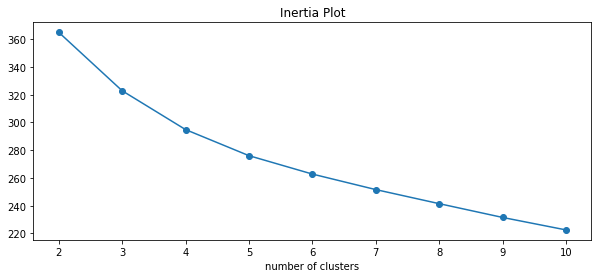

In [10]:
# finding optimal number of clusters
def kmeans_optimal_clusters(data):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    
    # sum of squared error = clusters inertia
    clusters_inertia = []
    
    # k-means properties
    kmeans_kwargs = {'init': 'k-means++', 'max_iter': 300}
    
    # calculate scores for clusters between 2 and 10
    for i in range(2, data.shape[1]):
        kmeans = KMeans(n_clusters=i, **kmeans_kwargs).fit(data)
        clusters_inertia.append(kmeans.inertia_)
    
    # visualize results
    plt.figure(figsize=(10, 4))
    plt.plot(range(2, data.shape[1]), clusters_inertia, marker='o', markersize=6)
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Inertia Plot')
    plt.xlabel('number of clusters')
    plt.show()
    
kmeans_optimal_clusters(data=df2)

Determining the elbow point in the SSE curve is not always straightforward. This graph has no clear "elbow" visible. Three clusters should be a fair choice. Another way for choosing the best number of clusters is by silhouette scores and Caliński-Harabasz scores.

Number of Clusters = 2: 	Silhouette Score: 0.235842, 	Caliński-Harabasz Score: 1393.438255
Number of Clusters = 3: 	Silhouette Score: 0.181216, 	Caliński-Harabasz Score: 1045.651469
Number of Clusters = 4: 	Silhouette Score: 0.163686, 	Caliński-Harabasz Score: 888.286273
Number of Clusters = 5: 	Silhouette Score: 0.161281, 	Caliński-Harabasz Score: 778.895819
Number of Clusters = 6: 	Silhouette Score: 0.141839, 	Caliński-Harabasz Score: 694.06259
Number of Clusters = 7: 	Silhouette Score: 0.139087, 	Caliński-Harabasz Score: 631.782081
Number of Clusters = 8: 	Silhouette Score: 0.134254, 	Caliński-Harabasz Score: 585.613945
Number of Clusters = 9: 	Silhouette Score: 0.132585, 	Caliński-Harabasz Score: 554.952856
Number of Clusters = 10: 	Silhouette Score: 0.133968, 	Caliński-Harabasz Score: 533.886644


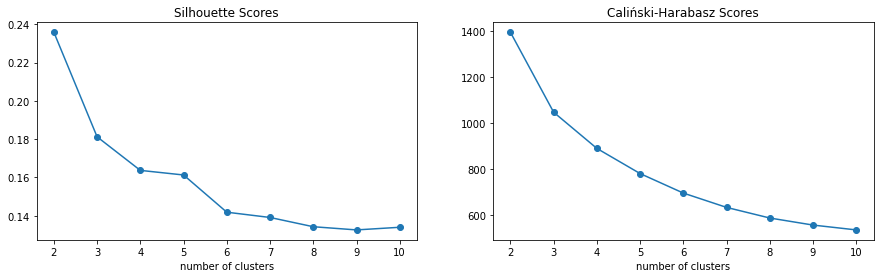

In [11]:
# finding optimal number of clusters with silhouette and Caliński-Harabasz coefficients
def kmeans_hyperparameter_tuning(data):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    from sklearn.model_selection import ParameterGrid

    # grid of clusters for tuning
    parameters = list(range(2, data.shape[1]))

    # instantiating ParameterGrid
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    # k-means properties
    kmeans_kwargs = {'init': 'k-means++', 'max_iter': 300}
    
    # instantiating k-means model
    kmeans_model = KMeans(**kmeans_kwargs)
    # silhouette coefficients
    silhouette_scores = []
    # Caliński-Harabasz coefficients
    cal_har_scores = []

    # calculating scores for each cluster
    for i, j in zip(parameter_grid, parameters):
        kmeans_model.set_params(**i)
        kmeans_model.fit(data)

        # appending lists
        ss = silhouette_score(data, kmeans_model.labels_)
        chs = calinski_harabasz_score(data, kmeans_model.labels_)
        silhouette_scores += [ss]
        cal_har_scores += [chs]
        
        print('Number of Clusters = {}: \tSilhouette Score: {}, \tCaliński-Harabasz Score: {}'
              .format(j, round(ss, 6), round(chs, 6)))

    # visualizing results
    fig = plt.figure(figsize=(15, 4))
    
    # subplot 1
    plt.subplot(1, 2, 1)
    plt.plot(range(2, data.shape[1]), silhouette_scores, marker='o', markersize=6)
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Silhouette Scores')
    plt.xlabel('number of clusters')
    
    # subplot 2
    plt.subplot(1, 2, 2)
    plt.plot(range(2, data.shape[1]), cal_har_scores, marker='o', markersize=6)
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Caliński-Harabasz Scores')
    plt.xlabel('number of clusters')
    plt.show()

kmeans_hyperparameter_tuning(data=df2)

There is a significant decrease from two clusters to three. From this point we have a gradual decline. Although, two clusters have the highest score value it might be too simplistic for this kind of data. The best option would be respectively three centers. We will provide this quantity in the training process.

Number of Fitted Variables: 11

#### Number of Instances Per Cluster ####
Cluster 0: 1568
Cluster 1: 1070
Cluster 2: 1323


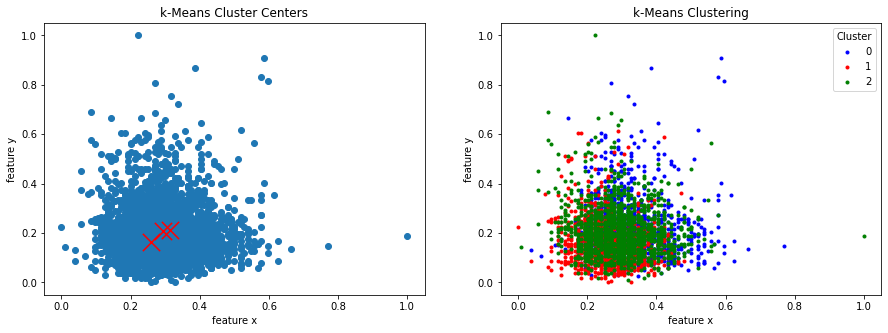

#### Centroid Coordinates [x, y] ####
Cluster 0: 	[0.314, 0.21]
Cluster 1: 	[0.26, 0.162]
Cluster 2: 	[0.293, 0.208]


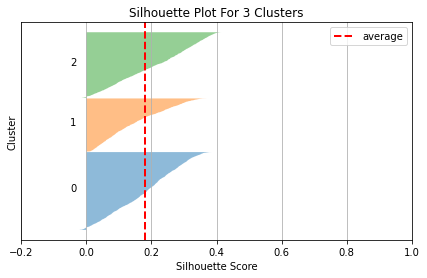

#### Model Validation ####
Average Silhouette Score: 0.1812330937503458
Caliński-Harabasz Score: 1045.651378753605
Davies-Bouldin Index: 1.766671045199386


In [12]:
# performing k-means clustering
def kmeans_clustering(n_clusters, data):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
    
    # fitting model
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300)
    pred_y = kmeans.fit_predict(data)
    
    # new data with predicted clusters
    array = np.append(data, pred_y.reshape(-1, 1), axis=1)
    
    # number of features
    print('Number of Fitted Variables:', kmeans.n_features_in_)
    
    # counting instances for each cluster
    print('\n#### Number of Instances Per Cluster ####')
    for i in range(0, n_clusters):
        print('Cluster {}: {}'.format(i, (array[:,-1] == i).sum()))
    
    # visualizing results
    plt.figure(figsize=(15, 5))
    
    # subplot 1
    plt.subplot(1, 2, 1)
    plt.scatter(x=data[:, 0], y=data[:, 1])
    plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
    plt.title('k-Means Cluster Centers')
    plt.xlabel('feature x')
    plt.ylabel('feature y')
    
    colors = ['blue', 'red', 'green', 'cyan', 'magenta']
    
    # subplot 2
    plt.subplot(1, 2, 2)
    for i, color in zip(range(0, n_clusters), colors):
        plt.scatter(x=array[:, 0][(array[:, -1] == i)], y=array[:, 1][(array[:, -1] == i)], marker='.', color=color, label=i)
        
    plt.title('k-Means Clustering')
    plt.xlabel('feature x')
    plt.ylabel('feature y')
    plt.legend(loc='best', title='Cluster')
    plt.show()
    
    print('#### Centroid Coordinates [x, y] ####')
    for i in range(0, n_clusters):
        print('Cluster {}: \t[{}, {}]'.format(i, round(kmeans.cluster_centers_[i, 0], 3),
                                          round(kmeans.cluster_centers_[i, 1], 3)))
    
    # subplot 3
    plt.figure(figsize=(7, 4))
    
    # silhouette score for each sample
    silhouette_vals = silhouette_samples(data, pred_y)
    
    y_lower, y_upper = 0, 0     
    for i in range(n_clusters):
        
        # grouping and sorting silhouette scores
        cluster_silhouette_vals = silhouette_vals[pred_y == i]
        cluster_silhouette_vals.sort()

        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)

        # cluster label at the middle
        plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
        # new y_lower for next plot
        y_lower = y_upper + 10
    
    # plotting average silhouette score
    avg_score = (silhouette_vals).mean()
    plt.axvline(x=avg_score, color='red', linestyle='--', linewidth=2, label='average')
    plt.yticks([])
    plt.xlim([-0.2, 1])
    plt.title('Silhouette Plot For {} Clusters'.format(n_clusters))
    plt.xlabel('Silhouette Score')
    plt.ylabel('Cluster')
    plt.grid(axis='x')
    plt.legend(loc='upper right')
    plt.show()
    
    print('#### Model Validation ####')
    print('Average Silhouette Score:', silhouette_score(data, kmeans.labels_))
    print('Caliński-Harabasz Score:', calinski_harabasz_score(data, kmeans.labels_))
    print('Davies-Bouldin Index:', davies_bouldin_score(data, kmeans.labels_))

kmeans_clustering(n_clusters=3, data=df2)

The clustering is poor and far from perfect. We can see lots of overlapping within the data points. In geometrical content, each group has its own centroid (cluster center). The centroids are very close each other which also indicates poor grouping.

The silhouette plot displays the silhouette score for each sample (data point). The metrics are represented by bars which are stacked ascending (from bottom to top). The width of each cluster depends on the number of bars (instances) per cluster. The average silhouette score is represented by the red, dashed line in comparison to all metrics.

### 5. Agglomerative Clustering

Agglomerative clustering is a type of hierarchical clustering based on distance connectivity. It is a bottom-up approach, initially, each data point is a cluster of its own, further pairs of clusters are merged as one moves up the hierarchy in a dendrogram. The number of clusters is predetermined by the user. Clusters are assigned by cutting the dendrogram at a specified depth that results in *k* groups of smaller dendrograms. Hierarchical clustering methods often reveal the finer details about the relationships between data objects. One major weakness is that they are computationally expensive with respect to algorithm complexity.

The <code>linkage</code> criteria is a basic argument for this algorithm. We will leave the default choice - <code>ward</code>. This argument determines which distance to use between sets of observation. The <code>ward</code> option picks the two clusters to merge such that the variance within all clusters increases the least and works on most datasets.<br>
Another hyperparameter to define is the metric used to compute the linkage - <code>affinity</code>. If linkage is set as <code>ward</code>, only Euclidean distance is accepted.

Number of Clusters = 2: 	Silhouette Score: 0.186463, 	Caliński-Harabasz Score: 999.657223
Number of Clusters = 3: 	Silhouette Score: 0.127899, 	Caliński-Harabasz Score: 823.13008
Number of Clusters = 4: 	Silhouette Score: 0.128263, 	Caliński-Harabasz Score: 726.215387
Number of Clusters = 5: 	Silhouette Score: 0.117432, 	Caliński-Harabasz Score: 607.437806
Number of Clusters = 6: 	Silhouette Score: 0.124997, 	Caliński-Harabasz Score: 536.468717
Number of Clusters = 7: 	Silhouette Score: 0.123433, 	Caliński-Harabasz Score: 489.668954
Number of Clusters = 8: 	Silhouette Score: 0.098644, 	Caliński-Harabasz Score: 450.886685
Number of Clusters = 9: 	Silhouette Score: 0.073743, 	Caliński-Harabasz Score: 423.019718
Number of Clusters = 10: 	Silhouette Score: 0.076673, 	Caliński-Harabasz Score: 400.901769


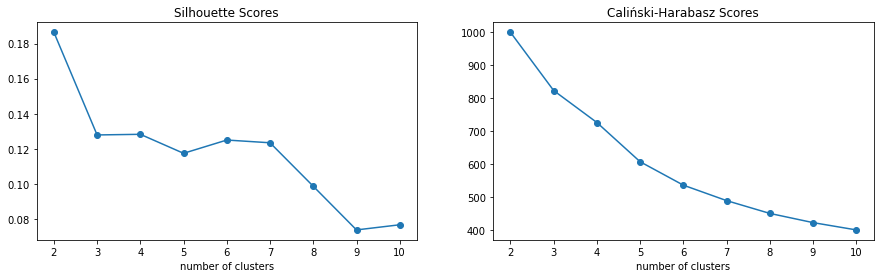

In [13]:
# finding optimal number of clusters with silhouette and Caliński-Harabasz coefficients
def agg_hyperparameter_tuning(data):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    from sklearn.model_selection import ParameterGrid

    # grid of clusters for tuning
    parameters = list(range(2, data.shape[1]))

    # instantiating ParameterGrid
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    # agglomerative clustering properties
    agg_kwargs = {'affinity': 'euclidean', 'linkage': 'ward'}
    
    # instantiating agglomerative model
    agg_clus = AgglomerativeClustering(**agg_kwargs)
    # silhouette coefficients
    silhouette_scores = []
    # Calinski-Harabasz coefficients
    cal_har_scores = []

    # calculating silhouette_score for each cluster
    for i, j in zip(parameter_grid, parameters):
        agg_clus.set_params(**i)
        agg_clus.fit(data)

         # appending lists
        ss = silhouette_score(data, agg_clus.labels_)
        chs = calinski_harabasz_score(data, agg_clus.labels_)
        silhouette_scores += [ss]
        cal_har_scores += [chs]
        
        print('Number of Clusters = {}: \tSilhouette Score: {}, \tCaliński-Harabasz Score: {}'
              .format(j, round(ss, 6), round(chs, 6)))

    # visualizing results
    fig = plt.figure(figsize=(15, 4))
    
    # subplot 1
    plt.subplot(1, 2, 1)
    plt.plot(range(2, data.shape[1]), silhouette_scores, marker='o', markersize=6)
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Silhouette Scores')
    plt.xlabel('number of clusters')
    
    # subplot 2
    plt.subplot(1, 2, 2)
    plt.plot(range(2, data.shape[1]), cal_har_scores, marker='o', markersize=6)
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Caliński-Harabasz Scores')
    plt.xlabel('number of clusters')
    plt.show()

agg_hyperparameter_tuning(data=df2)

Best choice for this model would be three or four clusters. Another way to detect the number of clusters in hierarchical clustering is a dendrogram. By observing the dendrograms, one can find the desired number of clusters.

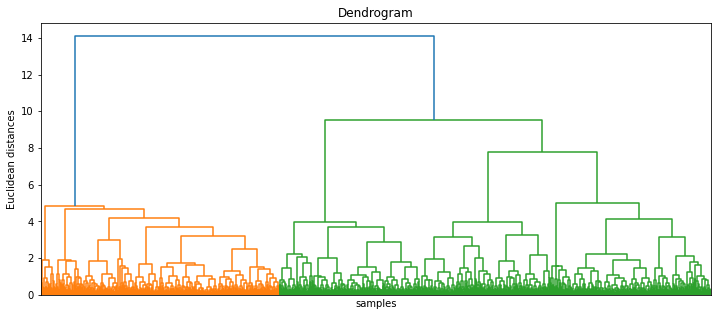

In [14]:
# finding optimal number of clusters with dendrogram
def plot_dendogram(data):
    from scipy.cluster.hierarchy import dendrogram, ward
    
    plt.figure(figsize=(12, 5))
    dendrogram = dendrogram(ward(data))
    plt.xticks([])
    plt.title('Dendrogram')
    plt.xlabel('samples')
    plt.ylabel('Euclidean distances')
    plt.show()
    
plot_dendogram(data=df2)

A dendrogram is a diagrammatic (tree based) representation of the hierarchical relationship between the data points. It visualizes the arrangement of the clusters produced by the corresponding analyses and is used to observe the output of hierarchical clustering (from bottom to top).

To determine the optimal number of clusters, we set a threshold distance and draw a horizontal line in such a way that it cuts the tallest vertical line (blue, left line). The number of clusters will be the number of vertical lines which are being intersected by the line drawn using the threshold. In this case the number of clusters will be two or three. Two is too simple and we will stick to three groups - distance 8.0.

Number of Fitted Variables: 11

#### Number of Instances Per Cluster ####
Cluster 0: 1717
Cluster 1: 1412
Cluster 2: 832


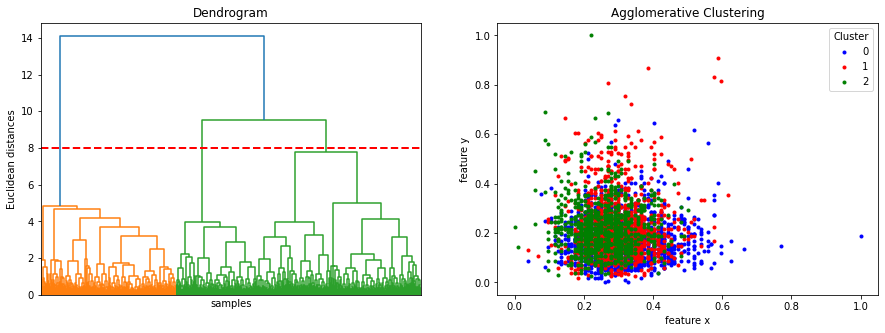

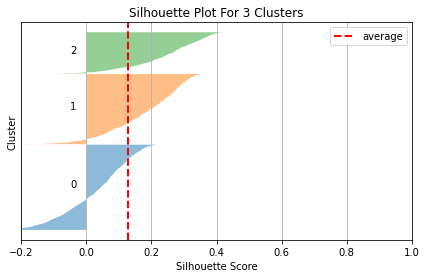

#### Model Validation ####
Average Silhouette Score: 0.12789869861880152
Caliński-Harabasz Score: 823.1300797620984
Davies-Bouldin Index: 2.1146003765973957


In [15]:
# performing agglomerative clustering
def agglomerative_clustering(n_clusters, data):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
    from scipy.cluster.hierarchy import dendrogram, ward
    
    # fitting model
    agg_clus = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    pred_y = agg_clus.fit_predict(data)
    
    # new data with clusters
    array = np.append(data, pred_y.reshape(-1, 1), axis=1)
    
    # number of features
    print('Number of Fitted Variables:', agg_clus.n_features_in_)
    
    # counting instances for each cluster
    print('\n#### Number of Instances Per Cluster ####')
    for i in range(0, n_clusters):
        print('Cluster {}: {}'.format(i, (array[:,-1] == i).sum()))
    
    # visualizing results
    plt.figure(figsize=(15, 5))
    
    # subplot 1
    plt.subplot(1, 2, 1)
    dendrogram = dendrogram(ward(data))
    plt.axhline(y=8, color='red', linestyle='--', linewidth=2)
    plt.xticks([])
    plt.title('Dendrogram')
    plt.xlabel('samples')
    plt.ylabel('Euclidean distances')
    
    colors = ['blue', 'red', 'green', 'cyan', 'magenta']
    
    # subplot 2
    plt.subplot(1, 2, 2)
    for i, color in zip(range(0, n_clusters), colors):
        plt.scatter(x=array[:, 0][(array[:, -1] == i)], y=array[:, 1][(array[:, -1] == i)], marker='.', color=color, label=i)
        
    plt.title('Agglomerative Clustering')
    plt.xlabel('feature x')
    plt.ylabel('feature y')
    plt.legend(loc='best', title='Cluster')
    plt.show()
    
    # subplot 3
    plt.figure(figsize=(7, 4))
    
    # silhouette score for each sample
    silhouette_vals = silhouette_samples(data, pred_y)
    
    y_lower, y_upper = 0, 0     
    for i in range(n_clusters):
        
        # grouping and sorting silhouette scores
        cluster_silhouette_vals = silhouette_vals[pred_y == i]
        cluster_silhouette_vals.sort()

        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)

        # cluster label at the middle
        plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
        # new y_lower for next plot
        y_lower = y_upper + 10
    
    # plotting average silhouette score
    avg_score = (silhouette_vals).mean()
    plt.axvline(x=avg_score, color='red', linestyle='--', linewidth=2, label='average')
    plt.yticks([])
    plt.xlim([-0.2, 1])
    plt.title('Silhouette Plot For {} Clusters'.format(n_clusters))
    plt.xlabel('Silhouette Score')
    plt.ylabel('Cluster')
    plt.grid(axis='x')
    plt.legend(loc='upper right')
    plt.show()
    
    print('#### Model Validation ####')
    print('Average Silhouette Score:', silhouette_score(data, agg_clus.labels_))
    print('Caliński-Harabasz Score:', calinski_harabasz_score(data, agg_clus.labels_))
    print('Davies-Bouldin Index:', davies_bouldin_score(data, agg_clus.labels_))

agglomerative_clustering(n_clusters=3, data=df2)

The agglomerative model tends to lower the number of data points with each next cluster. The clusters are messy and we can spot lots of overlapping. Overall, the grouping process did not return desired results.

### 6. Spectral Clustering

Spectral clustering is a modern approach based on graph theory and standard linear algebra. It applies the clustering to a projection of the normalized Laplacian. This algorithm takes each data point as a graph node and uses graph partitioning to solve the clustering problem. In spectral clustering, the affinity, and not the absolute location (i.e. k-means), determines what points fall under which cluster. This model does not assume the shape of data and performs well on all kinds of distributions of data. Other common algorithms like k-means assume the shape of data as spherical. Due to fact that it is computationally expensive, it can have trouble working with very large datasets. Another disadvantage is that this model doesn't perform well with noisy data.

The <code>affinity</code> parameter describes how to construct the affinity matrix. We will check performance for two methods and plot the results:
* <code>rbf</code> - default option, the matrix is built by using a radial basis function (RBF) kernel.
* <code>nearest_neighbors</code> - the matrix is built by computing a graph of nearest neighbors.

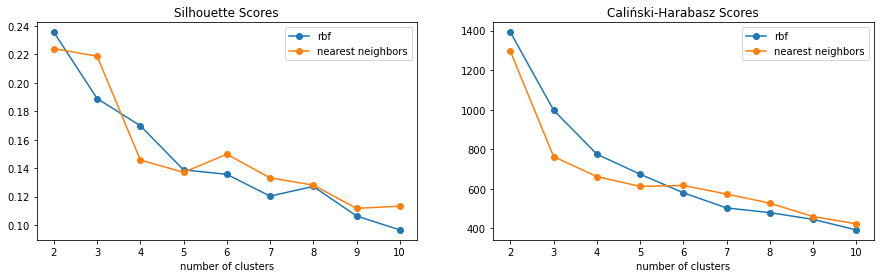

In [16]:
# finding optimal number of clusters and affinity matrix with silhouette and Caliński-Harabasz coefficients
def spec_hyperparameter_tuning(data):
    from sklearn.cluster import SpectralClustering
    from sklearn.metrics import silhouette_score, calinski_harabasz_score

    # silhouette coefficients
    silhouette_scores_rbf = []
    silhouette_scores_nn = []
    
    # Caliński-Harabasz coefficients
    cal_har_scores_rbf = []
    cal_har_scores_nn = []

    # calculating silhouette_score for each cluster and affinity method
    for i in range(2, data.shape[1]):
        spec_clus_rbf = SpectralClustering(n_clusters=i, affinity='rbf')
        spec_clus_nn = SpectralClustering(n_clusters=i, affinity='nearest_neighbors')
        spec_clus_rbf.fit(data)
        spec_clus_nn.fit(data)

        # appending lists
        ss_rbf = silhouette_score(data, spec_clus_rbf.labels_)
        ss_nn = silhouette_score(data, spec_clus_nn.labels_)
        chs_rbf = calinski_harabasz_score(data, spec_clus_rbf.labels_)
        chs_nn = calinski_harabasz_score(data, spec_clus_nn.labels_)
        
        silhouette_scores_rbf += [ss_rbf]
        silhouette_scores_nn += [ss_nn]
        cal_har_scores_rbf += [chs_rbf]
        cal_har_scores_nn += [chs_nn]
    
    # visualizing results
    fig = plt.figure(figsize=(15, 4))
    
    # subplot 1
    plt.subplot(1, 2, 1)
    plt.plot(range(2, data.shape[1]), silhouette_scores_rbf, marker='o', markersize=6, label='rbf')
    plt.plot(range(2, data.shape[1]), silhouette_scores_nn, marker='o', markersize=6, label='nearest neighbors')
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Silhouette Scores')
    plt.xlabel('number of clusters')
    plt.legend(loc='best')
    
    # subplot 2
    plt.subplot(1, 2, 2)
    plt.plot(range(2, data.shape[1]), cal_har_scores_rbf, marker='o', markersize=6, label='rbf')
    plt.plot(range(2, data.shape[1]), cal_har_scores_nn, marker='o', markersize=6, label='nearest neighbors')
    plt.xticks(np.arange(2, data.shape[1]))
    plt.title('Caliński-Harabasz Scores')
    plt.xlabel('number of clusters')
    plt.legend(loc='best')
    plt.show()

spec_hyperparameter_tuning(data=df2)

The affinity with a nearest neighbor connectivity matrix is the best choice for three clusters. We will apply this affinity option.

Number of Fitted Variables: 11

#### Number of Instances Per Cluster ####
Cluster 0: 1940
Cluster 1: 1942
Cluster 2: 79


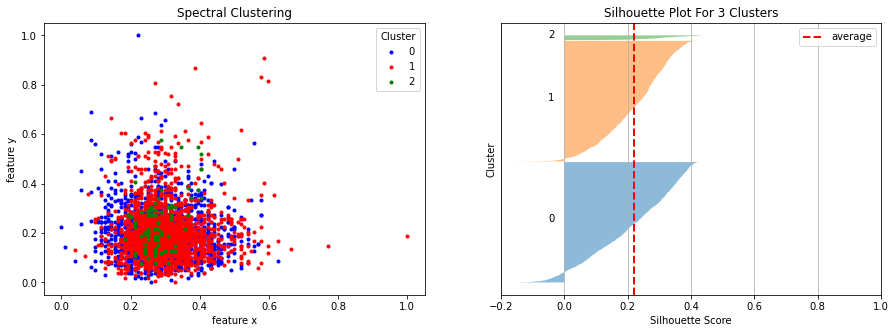

#### Model Validation ####
Average Silhouette Score: 0.2187357462871433
Caliński-Harabasz Score: 762.8059499570387
Davies-Bouldin Index: 1.5179848296932725


In [17]:
# performing spectral clustering
def spectral_clustering(n_clusters, data):
    from sklearn.cluster import SpectralClustering
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
    
    # fitting model
    spec_clus = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
    pred_y = spec_clus.fit_predict(data)
    
    # new data with clusters
    array = np.append(data, pred_y.reshape(-1, 1), axis=1)
    
    # number of features
    print('Number of Fitted Variables:', spec_clus.n_features_in_)
    
    # counting instances for each cluster
    print('\n#### Number of Instances Per Cluster ####')
    for i in range(0, n_clusters):
        print('Cluster {}: {}'.format(i, (array[:,-1] == i).sum()))
    
    # visualizing results
    plt.figure(figsize=(15, 5))
    
    # subplot_1
    plt.subplot(1, 2, 1)
    colors = ['blue', 'red', 'green', 'cyan', 'magenta']
    
    for i, color in zip(range(0, n_clusters), colors):
        plt.scatter(x=array[:, 0][(array[:, -1] == i)], y=array[:, 1][(array[:, -1] == i)], marker='.', color=color, label=i)
        
    plt.title('Spectral Clustering')
    plt.xlabel('feature x')
    plt.ylabel('feature y')
    plt.legend(loc='best', title='Cluster')
    
    # subplot_2
    plt.subplot(1, 2, 2)
    
    # silhouette score for each sample
    silhouette_vals = silhouette_samples(data, pred_y)
    
    y_lower, y_upper = 0, 0     
    for i in range(n_clusters):
        
        # grouping and sorting silhouette scores
        cluster_silhouette_vals = silhouette_vals[pred_y == i]
        cluster_silhouette_vals.sort()

        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)

        # cluster label at the middle
        plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
        # new y_lower for next plot
        y_lower = y_upper + 10
    
    # plotting average silhouette score
    avg_score = (silhouette_vals).mean()
    plt.axvline(x=avg_score, color='red', linestyle='--', linewidth=2, label='average')
    plt.yticks([])
    plt.xlim([-0.2, 1])
    plt.title('Silhouette Plot For {} Clusters'.format(n_clusters))
    plt.xlabel('Silhouette Score')
    plt.ylabel('Cluster')
    plt.grid(axis='x')
    plt.legend(loc='upper right')
    plt.show()
    
    print('#### Model Validation ####')
    print('Average Silhouette Score:', silhouette_score(data, spec_clus.labels_))
    print('Caliński-Harabasz Score:', calinski_harabasz_score(data, spec_clus.labels_))
    print('Davies-Bouldin Index:', davies_bouldin_score(data, spec_clus.labels_))
    
    # affinity matrix used for clustering
    #print('\nAffinity Matrix:\n', spec_clus.affinity_matrix_)

spectral_clustering(n_clusters=3, data=df2)

The spectral clustering returned very uneven clusters. Two first groups have almost identical quantity but the last cluster has a bizarre amount of data points. Unlike hierarchical clustering, the spectral grouping has a higher silhouette score. The Caliński-Harabasz coefficient presents overall worse separated clustering results.

To improve the grouping process we can implement decompositional functions to reduce data, such as PCA (principal component analysis), NMF (non-negative matrix factorization), or manifold learning. These unsupervised machine learning algorithms allow us to discard unnecessary features and remove noisy data. To reduce our data, we will try the PCA method and perform clustering on new data.

### 7. Dimensionality Reduction Using Principal Component Analysis (PCA)

The principal component analysis (PCA) is an unsupervised method which inverses a dataset so that these features are not statistically correlated. It projects the observations onto the principal components keeping most of the variance. The motivation of this technique is to reduce the features dimentionality while losing a small amount of information. It does this by finding the directions of maximum variance in the data and projecting the data onto those directions.

Explained variance is a statistical measure of how much variation in a dataset can be attributed to each of the principal components (eigenvectors) generated by a PCA. It refers to the amount of variability in a dataset that can be attributed to each individual eigenvector. This allows us to rank the components in order of importance, and focus on the most important ones when interpreting the results of our analysis (discarding the least significant).

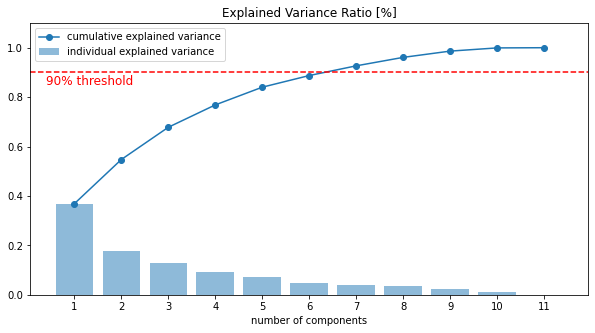

In [18]:
# finding optimal number of components with explained variance
def pca_optimal_components(data):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.decomposition import PCA
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    pca = PCA(n_components=None).fit(scaled_data)
    
    # percentage of variance explained by each of the selected components
    y = np.cumsum(pca.explained_variance_ratio_)
    
    # visualizing results
    plt.figure(figsize=(10, 5))
    plt.ylim(0.0, 1.1)
    
    plt.plot(range(1, data.shape[1]+1), y, marker='o', markersize=6, label='cumulative explained variance')
    plt.bar(range(1, data.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, label='individual explained variance')
    
    plt.title('Explained Variance Ratio [%]')
    plt.xlabel('number of components')
    
    plt.axhline(y=0.9, color='red', linestyle='--')
    plt.text(x=0.4, y=0.85, s='90% threshold', color='red', fontsize=12)
    plt.xticks(np.arange(1, data.shape[1]+1))
    plt.legend(loc='best')
    plt.show()

pca_optimal_components(data=df2)

The plot shows the variances explained by each variable. It displays that cumulative explained variance is inversed to individual explained variance.
The line plot determines which principal components to keep and which ones to discard. Most of the time, we use enough eigenvectors so that they explain 95% to 99% of the variation in the dataset. By examining the above figure, we can conclude that first 6 dimensions contain most of the information.

In [19]:
# performing dimensionality reduction with PCA
def reduce_dimensionality(n_components, data):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.decomposition import PCA
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    return pca_result

df3 = reduce_dimensionality(n_components=6, data=df2)
df3

array([[-0.37376295, -0.1461661 ,  0.01459762,  0.0286885 ,  0.04700836,
        -0.05763429],
       [-0.12220269,  0.1014675 , -0.08277814, -0.02970811, -0.11097741,
         0.02710799],
       [-0.05556597, -0.02265431, -0.06342425, -0.05313953, -0.04707583,
         0.1466882 ],
       ...,
       [-0.14777124, -0.13990322, -0.008534  , -0.0900996 , -0.14365979,
        -0.1279622 ],
       [ 0.41409829,  0.04268417, -0.1525949 ,  0.03149197,  0.03856393,
        -0.03502136],
       [ 0.26234653, -0.05374422, -0.19160334, -0.0793331 ,  0.02902432,
        -0.01109314]])

### 8. Clustering After Reducing Dimensions

We will implement the new, reduced data and illustrate results again. The number of clusters will remain untouched.

Number of Fitted Variables: 6

#### Number of Instances Per Cluster ####
Cluster 0: 1075
Cluster 1: 1308
Cluster 2: 1578


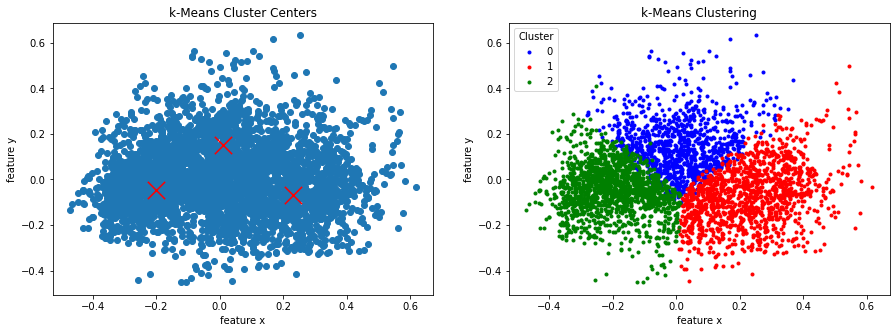

#### Centroid Coordinates [x, y] ####
Cluster 0: 	[0.01, 0.15]
Cluster 1: 	[0.232, -0.069]
Cluster 2: 	[-0.199, -0.045]


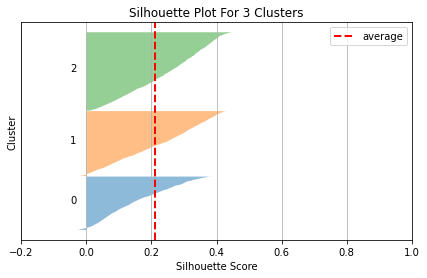

#### Model Validation ####
Average Silhouette Score: 0.21155794285124466
Caliński-Harabasz Score: 1261.7119558794243
Davies-Bouldin Index: 1.6023860204028868


In [20]:
# 1. k-means clustering
kmeans_clustering(n_clusters=3, data=df3)

Number of Fitted Variables: 6

#### Number of Instances Per Cluster ####
Cluster 0: 1886
Cluster 1: 1382
Cluster 2: 693


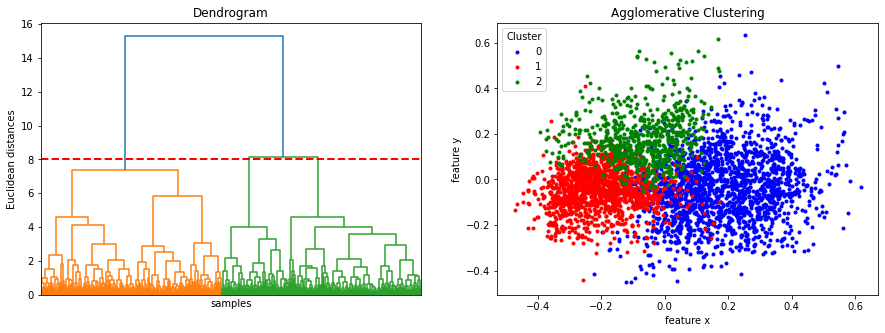

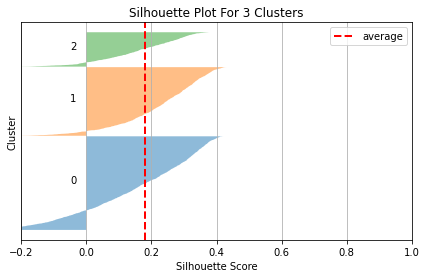

#### Model Validation ####
Average Silhouette Score: 0.18118325928564144
Caliński-Harabasz Score: 1033.034710921014
Davies-Bouldin Index: 1.6782539501862628


In [21]:
# 2. agglomerative clustering
agglomerative_clustering(n_clusters=3, data=df3)

Number of Fitted Variables: 6

#### Number of Instances Per Cluster ####
Cluster 0: 1229
Cluster 1: 1403
Cluster 2: 1329


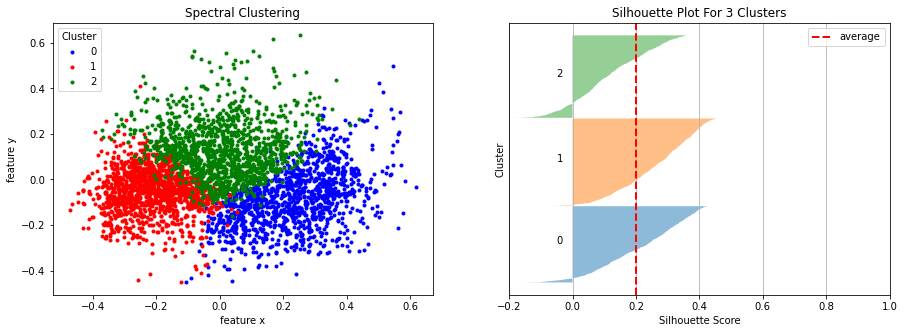

#### Model Validation ####
Average Silhouette Score: 0.2004263051682868
Caliński-Harabasz Score: 1204.9507536719123
Davies-Bouldin Index: 1.6377597039277862


In [22]:
# 3. spectral clustering
spectral_clustering(n_clusters=3, data=df3)

Below are metrics we used to evaluate all three models and the quantity of data points divided into each cluster through the processing:

| Method            | Silhouette | Caliński-<br>Harabasz | Davies-<br>Bouldin | Cluster 0 | Cluster 1 | Cluster 2 |
|-------------------|------------|-----------------------|--------------------|-----------|-----------|-----------|
| **k-Means**       | 0.2116     | 1261.7120             | 1.6024             | 1075      | 1308      | 1578      |
| **Agglomerative** | 0.1812     | 1033.0347             | 1.6782             | 1886      | 1382      | 693       |
| **Spectral**      | 0.2004     | 1204.9508             | 1.6378             | 1229      | 1403      | 1329      |

The results after dimensionality reduction improved, especially for the agglomerative method. The scores are higher and clustering process looks more cleaner. The k-means algorithm performed the best on this dataset according to its scores. The hierarchical clustering performed the worst. The algorithm's division is still messy. The are no clear boundaries between the groups. Also, the quantity of data points per cluster are inbalanced. The other algorithms returned similar number of instances.

### 9. Summary

This notebook introduced a range of unsupervised learning algorithms that can be applied for exploratory data analysis and preprocessing on white wine dataset. Having the right representation of the data is often crucial for unsupervised learning to succeed, and preprocessing and decomposition methods play an important part in data preparation. Unlike supervised machine learning, clustering is much more challenging to evaluate and it may be hard to quantify the usefulness of an unsupervised algorithm.

We have proved that dimensionality reduction is an essential tool to make sense of the data in the absence of supervision information. Applying PCA method improved the clustering process. Any further enhancing should be in removing possible outliers in the dataset. Overall, clustering can be a useful exploration tool for identifying homogeneous groups and pattern recognition within the data. This approach could help us understand more about the data before performing supervised tasks and develop more refine models.